In [3]:
import pandas as pd
from sqlalchemy import create_engine, text
import os


In [4]:
user = os.environ.get("DB_USER")
pw = os.environ.get("DB_PASSWORD")
db = os.environ.get("DB_USER")
host = os.environ.get("DB_HOST")
port = os.environ.get("DB_PORT")


uri = f"postgresql+psycopg2://{user}:{pw}@{host}:{port}/{db}"
engine = create_engine(uri)


In [5]:
query = text("SELECT * FROM records_2min_clean;")
conn = engine.connect()
df = pd.read_sql(query, conn)
conn.close()

In [6]:
df.columns

Index(['time', 'device_id', 'mass_concentration_pm1p0',
       'mass_concentration_pm2p5', 'mass_concentration_pm4p0',
       'mass_concentration_pm10p0', 'ambient_humidity', 'ambient_temperature',
       'voc_index', 'nox_index', 'hour', 'minute_of_hour', 'day_of_week',
       'day_name'],
      dtype='object')

In [7]:
cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0']
print(len(df))

for col in cols:
  df.loc[df[col] > 100, col] = 100


102760


In [8]:
df.loc[df['nox_index'] > 10, 'nox_index'] = 10

In [9]:
df.describe()

,device_id,mass_concentration_pm1p0,mass_concentration_pm2p5,mass_concentration_pm4p0,mass_concentration_pm10p0,ambient_humidity,ambient_temperature,voc_index,nox_index,hour,minute_of_hour,day_of_week
count,102760.000000,102760.000000,102760.000000,102760.000000,102760.000000,101627.000000,101627.000000,101627.000000,101627.000000,102760.000000,102760.000000,102760.000000
mean,34.701781,13.359427,14.588962,15.082623,15.324259,74.343252,10.392810,113.824097,1.438332,11.521983,28.974173,3.962554
std,3.034278,13.675763,14.153799,14.127824,14.131397,15.365621,3.585349,59.059609,0.973241,6.921132,17.302504,2.047081
min,31.000000,0.000000,0.000000,0.000000,0.000000,23.120000,1.170000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,32.000000,4.200000,5.225000,5.725000,5.933333,63.569167,8.107111,77.000000,1.000000,6.000000,14.000000,2.000000
50%,34.000000,8.166667,9.300000,10.000000,10.300000,75.310000,10.090000,100.000000,1.000000,12.000000,28.000000,4.000000
75%,37.000000,16.800000,17.900000,18.327083,18.700000,85.900000,12.388000,134.000000,2.000000,18.000000,44.000000,6.000000
max,40.000000,100.000000,100.000000,100.000000,100.000000,100.000000,36.490000,499.000000,10.000000,23.000000,58.000000,7.000000


Column transformer and the pipeline

In [10]:
from pickle import TRUE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, OneHotEncoder, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import datetime as dt

#### Building a pipeline
class LSTMInputSequenceCreator(BaseEstimator, TransformerMixin):
    def __init__(self, sequence_length, location_col='pass_location_nickname', max_interval=dt.timedelta(minutes=30),stride=1):
        """
            Args:
                sequence_length (int): The length of every LSTM sequence
                max_interval (datetime.Timedelta): The maximum allowed difference between the delta between two consecutive timestamps and the mode delta to impute
                stride (int): The number of steps to move the sequence window by
        """
        self.sequence_length = sequence_length
        self.stride = stride
        self.interval_length = None
        self.allowed_interval_error = max_interval
        self.location_col = location_col
        self.columns = None

    def fit(self, X, y=None):
        self.columns = X.columns
        try:
            X = [x for x in self._split_dataframe_by_location(X)]
            print('N locations: ', len(X))
            self.set_interval_length(X)
        except KeyError:
            self.set_interval_length(X)
        return self

    def transform(self, X):
        print('Transforming')
        X = self.split_dataframe(X)
        print("Dataframe splitted")
        sequences = []
        targets = []

        processed = 0
        for i in range(len(X)):
            X[i] = self.interpolate_missing_timestamps(X[i])
            processed += len(X[i])
            if len(X[i]) < self.sequence_length:
                continue
            sequence, target = self._create_3d_array(X[i])
            sequences.append(sequence)
            targets.append(target)
            print(f'{processed} number of datapoints processed')
        sequences = np.concatenate(sequences)
        targets = np.concatenate(targets)
        return sequences, targets

    def type_check(self, dataframe):
        # Check if the index is a DateTimeIndex
        if isinstance(dataframe.index, pd.DatetimeIndex):
            # Check if all columns are int, float, or transformable to int or float
            if all(dataframe[col].dtype in [np.int64, np.float64] or pd.to_numeric(dataframe[col], errors='raise') for col in dataframe.columns):
                return dataframe.apply(pd.to_numeric, errors='raise')
            else:
                raise ValueError("The index is a DateTimeIndex, but some columns are not int, float, or transformable to int or float.")
        else:
            raise ValueError("The index is not a DateTimeIndex.")



    def interpolate_missing_timestamps(self, df):
        """
            Takes a list of dataframes and checks for missing timestamps
            If there are missing timestamps, the missing timestamps are imputed by linear interpolation
        """
        df = self.type_check(df)
        new_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=self.interval_length)
        df_reindexed = df.reindex(df.index.union(new_index)).sort_index()

        new_df = df_reindexed.interpolate(method='time')
        new_df = new_df.reindex(new_index)

        return new_df

    def _create_3d_array(self, dataframe, drop_time=True):
        """
            Creates LSTM input sequences from a dataframe

            Args:
                dataframe (pd.DataFrame): The sequence dataframe
                drop_time (Boolean): Determines if the Day and Week columns should be dropped from the targets

            Returns:
                tuple(np.Array, np.Array): A tuple containing the sequences and the targets which are the consecutive values of the sequences
        """
        sequences = None
        targets = None

        # Convert dataframe to numpy array
        if isinstance(dataframe, pd.DataFrame):
            data = dataframe.values
            columns = dataframe.columns
            if drop_time:
              keep_columns = [i for i, col in enumerate(columns) if 'day' not in col and 'hour' not in col]

        elif isinstance(dataframe, np.ndarray):
            data = dataframe
            if drop_time:
              raise ValueError('The time columns can only be dropped if the input data is a dataframe')

        else:
            raise ValueError("The dataframe must be a pandas dataframe or a numpy array")
        # Create sequences
        for i in range(0, len(data) - self.sequence_length, self.stride):
            sequence = data[i:i+self.sequence_length]
            n, f = sequence.shape
            sequence = sequence.reshape((1, n, f))
            target = data[i+self.sequence_length]

            if drop_time:
              target = target[keep_columns]

            out = len(target)
            target = target.reshape((1, out))
            if sequences is None:
                sequences = sequence
                targets = target
            else:
                sequences = np.concatenate([sequences, sequence])
                targets = np.concatenate([targets, target])

        # Convert sequences and targets to numpy arrays
        return sequences, targets

    def set_interval_length(self, data):
        """
            Sets the mode interval length of the dataframe

            Args:
                dataframe (pd.DataFrame): The sequence dataframe
                on_index (bool): If True, the interval length will be set based on the index of the dataframe which should be a timeseries
                timestamp_column (str): The name of the column to use as the timestamp (only applicable if 'on_index' is False)
        """
        if type(data) == list:
            for df in data:

                if type(df) != pd.DataFrame:
                    raise ValueError("All elements of the list must be pandas dataframes")
                if not isinstance(df.index, pd.DatetimeIndex):
                    raise ValueError("The index of the dataframes must be a datetime index")

            self.interval_length = pd.concat([df.index.round('5s').to_series().diff() for df in data]).mode().squeeze()




        elif type(data) == pd.DataFrame:
            if not isinstance(data.index, pd.DatetimeIndex):
                raise ValueError("The index of the dataframe must be a datetime index")
            self.interval_length = data.index.round('5s').to_series().diff().mode().squeeze()


    def _split_dataframe_by_location(self, df):
        """
            Splits a dataframe into sub-dataframes based on the location_nickname column
        """
        for name in df[self.location_col].unique():
            yield name, df[df[self.location_col] == name].drop(columns=self.location_col)


    def split_dataframe(self, dataframe):

        new_dataframes = []
        previous_timestamp = None
        current_group = []
        total = 0
        if self.location_col in dataframe.columns:

            for name, df in self._split_dataframe_by_location(dataframe):
                print(f'Total splitted: {total}')
                total += len(df)
                for timestamp in df.index:
                    if previous_timestamp is None:
                        current_group.append(timestamp)
                        previous_timestamp = timestamp

                    else:

                        timedelta = timestamp - previous_timestamp

                        if timedelta > self.allowed_interval_error:
                            new_dataframes.append(df.loc[current_group])
                            current_group = []
                            current_group.append(timestamp)
                            previous_timestamp = timestamp

                        else:
                            current_group.append(timestamp)
                            previous_timestamp = timestamp

                new_dataframes.append(df.loc[current_group])
                current_group = []
                previous_timestamp = None
        else:
            raise(ValueError(f"The dataframe must have a {self.location_col} column, the other option is not yet implemented"))
        return new_dataframes

Column transformer

In [11]:

rb_cols = ['mass_concentration_pm1p0', 'mass_concentration_pm2p5', 'mass_concentration_pm4p0', 'mass_concentration_pm10p0', 'voc_index']
mm_cols = ['ambient_humidity','ambient_temperature', 'nox_index']
cat_cols = ['hour', 'day_of_week']

# col_trans = ColumnTransformer([('mm_scaler', MinMaxScaler(), rb_cols+mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
col_trans = ColumnTransformer([('qt_scaler', QuantileTransformer(), rb_cols), ('mm_scaler', MinMaxScaler(), mm_cols), ('time', OneHotEncoder(sparse_output=False), cat_cols),  ('pass', 'passthrough',  ['device_id'])],remainder='drop')
col_trans.set_output(transform='pandas')


ColumnTransformer(transformers=[('qt_scaler', QuantileTransformer(),
                                 ['mass_concentration_pm1p0',
                                  'mass_concentration_pm2p5',
                                  'mass_concentration_pm4p0',
                                  'mass_concentration_pm10p0', 'voc_index']),
                                ('mm_scaler', MinMaxScaler(),
                                 ['ambient_humidity', 'ambient_temperature',
                                  'nox_index']),
                                ('time', OneHotEncoder(sparse_output=False),
                                 ['hour', 'day_of_week']),
                                ('pass', 'passthrough', ['device_id'])])

In [12]:
all_data = df

In [13]:
all_data.columns

Index(['time', 'device_id', 'mass_concentration_pm1p0',
       'mass_concentration_pm2p5', 'mass_concentration_pm4p0',
       'mass_concentration_pm10p0', 'ambient_humidity', 'ambient_temperature',
       'voc_index', 'nox_index', 'hour', 'minute_of_hour', 'day_of_week',
       'day_name'],
      dtype='object')

In [14]:
print(len(all_data))
col_trans.fit(all_data)

102760


ColumnTransformer(transformers=[('qt_scaler', QuantileTransformer(),
                                 ['mass_concentration_pm1p0',
                                  'mass_concentration_pm2p5',
                                  'mass_concentration_pm4p0',
                                  'mass_concentration_pm10p0', 'voc_index']),
                                ('mm_scaler', MinMaxScaler(),
                                 ['ambient_humidity', 'ambient_temperature',
                                  'nox_index']),
                                ('time', OneHotEncoder(sparse_output=False),
                                 ['hour', 'day_of_week']),
                                ('pass', 'passthrough', ['device_id'])])

In [15]:
all_data.index = pd.to_datetime(all_data['time'])
new_data = col_trans.transform(all_data)
new_data.isna().sum()

qt_scaler__mass_concentration_pm1p0        0
qt_scaler__mass_concentration_pm2p5        0
qt_scaler__mass_concentration_pm4p0        0
qt_scaler__mass_concentration_pm10p0       0
qt_scaler__voc_index                    1133
mm_scaler__ambient_humidity             1133
mm_scaler__ambient_temperature          1133
mm_scaler__nox_index                    1133
time__hour_0.0                             0
time__hour_1.0                             0
time__hour_2.0                             0
time__hour_3.0                             0
time__hour_4.0                             0
time__hour_5.0                             0
time__hour_6.0                             0
time__hour_7.0                             0
time__hour_8.0                             0
time__hour_9.0                             0
time__hour_10.0                            0
time__hour_11.0                            0
time__hour_12.0                            0
time__hour_13.0                            0
time__hour

In [16]:
new_data.dropna(inplace=True)

In [17]:
############## Test vs Train
train = []
test = []

for id, df in new_data.groupby('pass__device_id', as_index=False):
    split = int(len(df) * 0.8)
    train.append(df.iloc[:split])
    test.append(df.iloc[split:])

train_df = pd.concat(train)
test_df = pd.concat(test)



In [18]:
len(train_df)

81297

In [19]:
lstm_formatter = LSTMInputSequenceCreator(sequence_length=30, location_col='pass__device_id', max_interval=dt.timedelta(minutes=10) ,stride=1)
dataframes = lstm_formatter.split_dataframe(new_data)

Total splitted: 0
Total splitted: 17561
Total splitted: 32310
Total splitted: 46037
Total splitted: 58865
Total splitted: 63686
Total splitted: 68407
Total splitted: 77351
Total splitted: 83555
Total splitted: 92845


In [20]:
dataframes[0]

,qt_scaler__mass_concentration_pm1p0,qt_scaler__mass_concentration_pm2p5,qt_scaler__mass_concentration_pm4p0,qt_scaler__mass_concentration_pm10p0,qt_scaler__voc_index,mm_scaler__ambient_humidity,mm_scaler__ambient_temperature,mm_scaler__nox_index,time__hour_0.0,time__hour_1.0,...,time__hour_21.0,time__hour_22.0,time__hour_23.0,time__day_of_week_1.0,time__day_of_week_2.0,time__day_of_week_3.0,time__day_of_week_4.0,time__day_of_week_5.0,time__day_of_week_6.0,time__day_of_week_7.0
time,,,,,,,,,,,,,,,,,,,,,
2024-03-02 10:28:00,0.022592,0.026683,0.033941,0.037719,0.000000,0.158299,0.545017,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:30:00,0.022592,0.026683,0.033941,0.037719,0.000000,0.158299,0.545017,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:32:00,0.016517,0.037037,0.059059,0.077116,0.000000,0.158299,0.545017,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:34:00,0.034034,0.037538,0.048196,0.053053,0.054054,0.195630,0.513448,0.050000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2024-03-02 10:36:00,0.033700,0.031664,0.038154,0.041263,0.153153,0.224506,0.484428,0.066667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 00:12:00,0.587704,0.570880,0.541475,0.530545,0.222680,0.525800,0.271574,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-05 00:14:00,0.585184,0.566493,0.537788,0.525534,0.217968,0.526104,0.271518,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024-03-05 00:16:00,0.585562,0.569570,0.540541,0.529530,0.216846,0.526394,0.271518,0.200000,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [21]:
def create_3d(dataframes):
  sequences = []
  targets = []
  processed = 0

  for i in range(len(dataframes)):

      sequence, target = lstm_formatter._create_3d_array(dataframes[i])
      if sequence is None:
          continue
      sequences.append(sequence)
      targets.append(target)
      processed += len(sequence)
      print(f'Processed {processed} data points')

  sequences = np.concatenate(sequences)
  targets = np.concatenate(targets)
  return sequences, targets

In [22]:
# X_all, y_all = create_3d(dataframes)

In [23]:
# with open('2min/30_10/X_train_qt.npy', 'wb') as f:
#     np.save(f, X_all)
# with open('2min/30_10/y_train_qt.npy', 'wb') as f:
#     np.save(f, y_all)

In [24]:
X_all = np.load('2min/30_10/X_train_qt.npy', allow_pickle=True)
y_all = np.load('2min/30_10/y_train_qt.npy', allow_pickle=True)

In [25]:
columns = new_data.columns.tolist()
columns.remove('pass__device_id')
print(columns)

['qt_scaler__mass_concentration_pm1p0', 'qt_scaler__mass_concentration_pm2p5', 'qt_scaler__mass_concentration_pm4p0', 'qt_scaler__mass_concentration_pm10p0', 'qt_scaler__voc_index', 'mm_scaler__ambient_humidity', 'mm_scaler__ambient_temperature', 'mm_scaler__nox_index', 'time__hour_0.0', 'time__hour_1.0', 'time__hour_2.0', 'time__hour_3.0', 'time__hour_4.0', 'time__hour_5.0', 'time__hour_6.0', 'time__hour_7.0', 'time__hour_8.0', 'time__hour_9.0', 'time__hour_10.0', 'time__hour_11.0', 'time__hour_12.0', 'time__hour_13.0', 'time__hour_14.0', 'time__hour_15.0', 'time__hour_16.0', 'time__hour_17.0', 'time__hour_18.0', 'time__hour_19.0', 'time__hour_20.0', 'time__hour_21.0', 'time__hour_22.0', 'time__hour_23.0', 'time__day_of_week_1.0', 'time__day_of_week_2.0', 'time__day_of_week_3.0', 'time__day_of_week_4.0', 'time__day_of_week_5.0', 'time__day_of_week_6.0', 'time__day_of_week_7.0']


In [26]:
X_all[0][10]

array([0.06056056, 0.05405405, 0.06256256, 0.06606607, 0.54251462,
       0.32628772, 0.42100793, 0.1       , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        ])

In [27]:
y_all[0]

array([0.03553554, 0.01751752, 0.01438315, 0.01401401, 0.47266211,
       0.32176769, 0.36402888, 0.1       ])

(array([630., 280., 245., 146.,  87., 126., 117., 105., 102.,  19.]),
 array([9.98431037e-04, 1.00898588e-01, 2.00798745e-01, 3.00698902e-01,
        4.00599059e-01, 5.00499216e-01, 6.00399372e-01, 7.00299529e-01,
        8.00199686e-01, 9.00099843e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

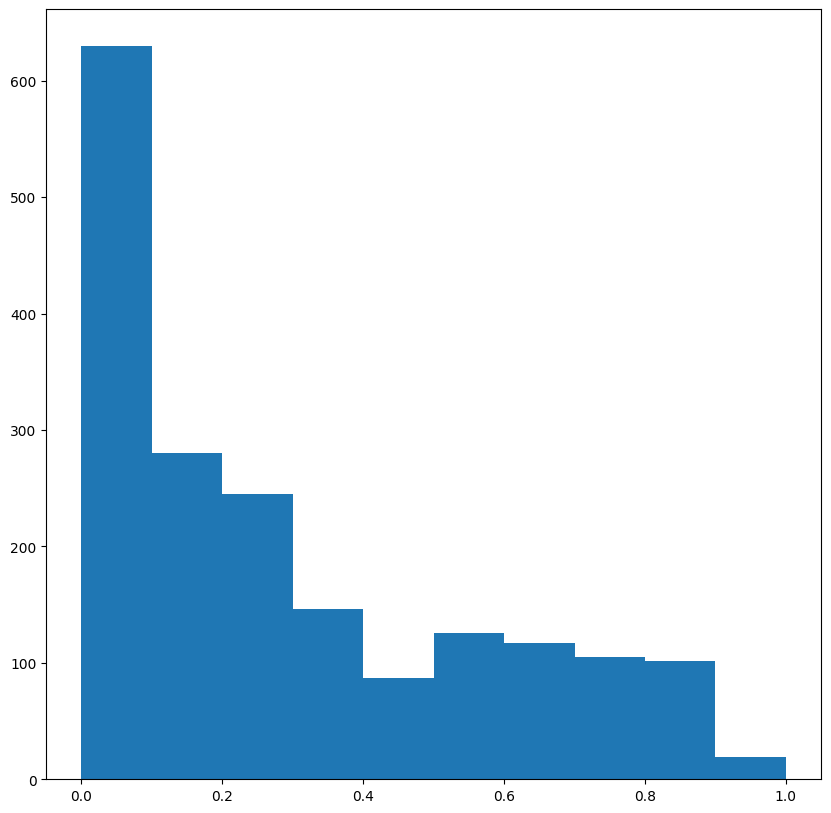

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.hist(dataframes[0]['qt_scaler__mass_concentration_pm10p0'])

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split



# Define the input shape
input_shape = X_all[0].shape
output_shape = y_all.shape[1]
print('Input shape:', input_shape)

# Define the LSTM-based neural network
inputs = Input(shape=input_shape)
lstm_layer = LSTM(256)(inputs)
dense = Dense(128, activation='relu')(lstm_layer)
dense = Dense(64, activation='relu')(dense)
output = Dense(output_shape, 'linear')(dense)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train the model
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, shuffle=True)

# Callbacks


early_stopping=EarlyStopping(patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, callbacks=[early_stopping, reduce_lr])

Input shape: (30, 39)
Epoch 1/50
553/553 [==============================] - 13s 7ms/step - loss: 0.0286 - mae: 0.1022 - val_loss: 0.0085 - val_mae: 0.0578 - lr: 1.0000e-04
Epoch 2/50
553/553 [==============================] - 3s 6ms/step - loss: 0.0082 - mae: 0.0552 - val_loss: 0.0080 - val_mae: 0.0538 - lr: 1.0000e-04
Epoch 3/50
553/553 [==============================] - 3s 6ms/step - loss: 0.0076 - mae: 0.0513 - val_loss: 0.0073 - val_mae: 0.0495 - lr: 1.0000e-04
Epoch 4/50
553/553 [==============================] - 4s 8ms/step - loss: 0.0074 - mae: 0.0496 - val_loss: 0.0074 - val_mae: 0.0506 - lr: 1.0000e-04
Epoch 5/50
553/553 [==============================] - 4s 7ms/step - loss: 0.0072 - mae: 0.0488 - val_loss: 0.0073 - val_mae: 0.0492 - lr: 1.0000e-04
Epoch 6/50
553/553 [==============================] - 3s 6ms/step - loss: 0.0071 - mae: 0.0480 - val_loss: 0.0071 - val_mae: 0.0477 - lr: 1.0000e-04
Epoch 7/50
553/553 [==============================] - 3s 6ms/step - loss: 0.0070 - 

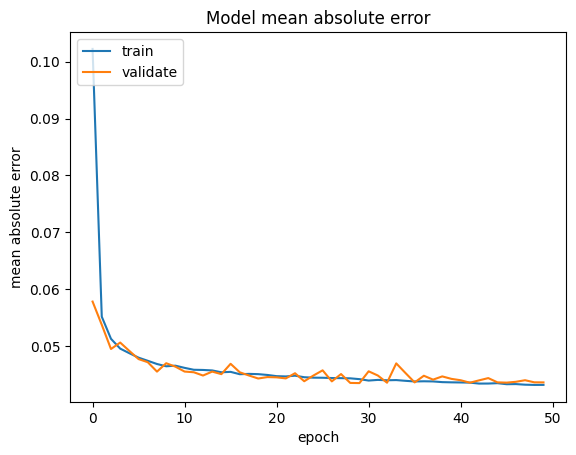

In [59]:
# summarize history for accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

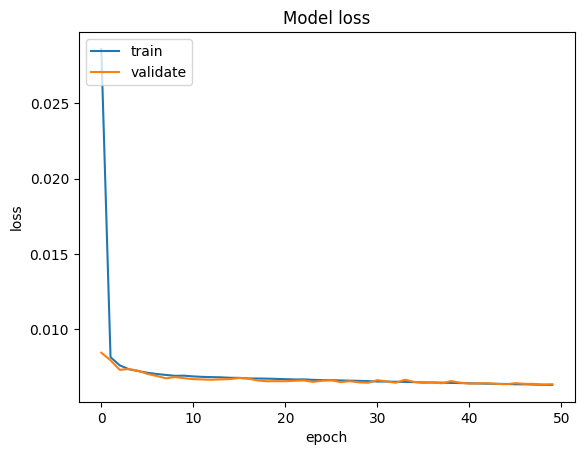

In [60]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

In [65]:
y_pred = model.predict(X_test)
y_pred.shape

615/615 [==============================] - 3s 3ms/step


(19652, 8)

In [66]:
def inverse_scale(col_trans, data):
  data = data.copy()
  # Inverse transform the data
  for transformer in col_trans.transformers_:
    if transformer[0] == 'rb_scaler':
      columns_rb = col_trans.output_indices_['rb_scaler']
      data[:, columns_rb] = transformer[1].inverse_transform(data[:, columns_rb])

    elif transformer[0] == 'mm_scaler':
        columns_mm = col_trans.output_indices_['mm_scaler']
        data[:, columns_mm] = transformer[1].inverse_transform(data[:, columns_mm])

    elif transformer[0] == 'qt_scaler':
        columns_qt = col_trans.output_indices_['qt_scaler']
        data[:, columns_qt] = transformer[1].inverse_transform(data[:, columns_qt])

    elif transformer[0] == 'time':
        pass
  return data

i_scaled = inverse_scale(col_trans, y_pred)
print(i_scaled[:10])

[[ 27.923037   29.84075    28.664246   29.339687  140.5739     52.42754
   13.4615755   1.0682502]
 [  9.616142    9.9         9.9053     10.1        67.22075    67.62397
   12.962861    1.1171155]
 [  5.9         7.1         8.1         8.559038  161.8841     63.489746
   11.588819    0.9258071]
 [ 16.734129   16.5        16.786552   16.4       101.         91.321686
   10.062625    2.0089889]
 [  2.7918658   3.3192866   3.5705485   3.792418   64.1315     85.02629
   10.356858    1.0690935]
 [ 14.595268   15.09351    14.671509   14.704834  112.         82.73388
    9.555666    1.9546857]
 [  5.0992174   5.5962477   6.2         6.309482   75.         72.81056
   11.869465    1.9045819]
 [  9.1         9.256105    9.6898365   9.9555235 110.741974   55.824486
    8.784478    0.9984689]
 [  5.7         6.          6.10131     6.2       140.51297    52.386585
   18.34135     1.0170501]
 [  9.2         9.4         9.89404     9.881297  174.38194    59.58272
    8.104399    1.0237453]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [67]:
y = inverse_scale(col_trans, y_test)
x_last = [x[-1] for x in X_test]
x_last = np.array(x_last)
print(x_last.shape)
x_last = x_last[:, :8]
x_last = inverse_scale(col_trans, x_last)
abs_errors = abs(i_scaled - y)
abs_errors_base = abs(x_last - y)
for i in range(8):
  print('Prediction error: ', abs_errors[:, i].mean())
  print('Baseline error: ', abs_errors_base[:, i].mean(), '\n')

(19652, 39)
Prediction error:  1.879993242575926
Baseline error:  2.059962845429423 

Prediction error:  2.0918070721037996
Baseline error:  2.3007259022777107 

Prediction error:  2.1803417583792037
Baseline error:  2.513459202438223 

Prediction error:  2.38500965096906
Baseline error:  2.566677262460664 

Prediction error:  18.695420298803413
Baseline error:  18.017377685446174 

Prediction error:  0.670540039540911
Baseline error:  0.3691829652117477 

Prediction error:  0.24282785624924502
Baseline error:  0.05879533960354616 

Prediction error:  0.1041625569351329
Baseline error:  0.03736879844209887 



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
